In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:

def get_pew():
    pew = pd.read_csv('./input/pew.csv')

    # List of "invalid" answers in pew dataset
    Nan_keywords = ['Refused', 'Don’t know', 'Don’t know (DO NOT READ)', 'Refused (DO NOT READ)',
                    '(VOL) Refused', "(VOL)\xa0Don't know"]

    pew = pew.replace(to_replace=Nan_keywords, value=np.NaN)

    # map "sentiment" to float values
    fav_dict = {'Somewhat favorable': 0.5, 'Very favorable': 1,
                'Somewhat unfavorable': -0.5, 'Very unfavorable': -1}

    pew = pew.replace(fav_dict)
    return pew

In [3]:
pew = get_pew()
# pew = pew[pew['country']]
pew.groupby(['country', 'year']).size().describe()

count     172.000000
mean     1125.936047
std       379.233548
min       801.000000
25%      1000.000000
50%      1007.500000
75%      1046.000000
max      3649.000000
dtype: float64

In [7]:

pew[pew['year'] == 2020]['country'].unique()


array(['United States', 'Netherlands', 'Spain', 'Germany', 'Denmark',
       'Japan', 'Italy', 'Sweden', 'United Kingdom', 'South Korea',
       'France', 'Australia', 'Canada', 'Belgium'], dtype=object)

/tmp/ipykernel_9769/811674548.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


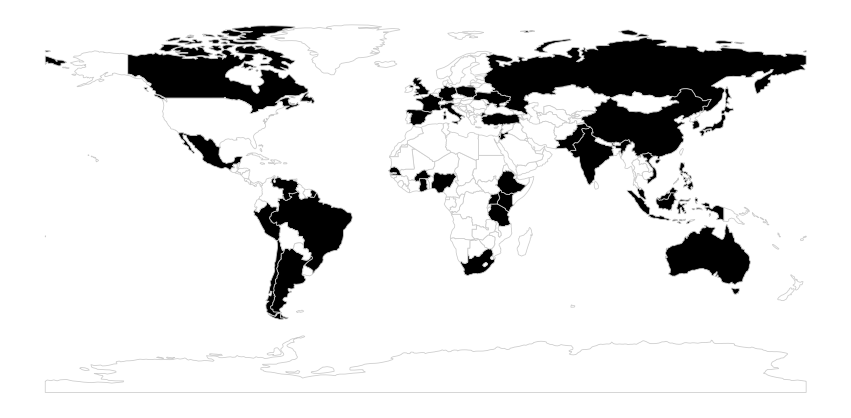

In [20]:
# Load shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df = pew[pew['year'] == 2015]
# Filter countries in Europe

countries_PEW = df['country'].unique()
world['in_PEW'] = world['name'].apply(lambda x: x in countries_PEW)

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the map
world.plot(column='in_PEW', cmap='binary', linewidth=0.8, ax=ax, edgecolor='0.8')

# Hide axis labels and ticks
ax.axis('off')

plt.savefig('./output/World2015.png', dpi=300,  bbox_inches='tight')

In [28]:
df = pd.read_csv('./input/fast_flair_total.csv')
pew = get_pew()
country_year_df = pew.groupby('country')['year'].unique().reset_index()
country_year_df['tuple'] = country_year_df[['country', 'year']].apply(
    lambda x: [(x['country'], y) for y in x['year']], axis=1)
country_year_tuple = country_year_df['tuple'].sum()
country_name_map = {
    "People's Republic of China": "China",
    "Kingdom of the Netherlands": "Netherlands",
    "United States of America": "United States",
}
excluded_countries = ['Palestinian territories', 'Denmark', 'Burkina Faso', "United States"]
df = df.replace(country_name_map)
country_year_df = country_year_df.explode(column='year')
country_year_df = country_year_df[country_year_df['country'].apply(lambda x: x not in excluded_countries)]
# country_year_df = country_year_df.set_index(['country', 'year'])
country_year_df.head()


,country,year,tuple
0,Argentina,2015,"[(Argentina, 2015), (Argentina, 2017), (Argent..."
0,Argentina,2017,"[(Argentina, 2015), (Argentina, 2017), (Argent..."
0,Argentina,2018,"[(Argentina, 2015), (Argentina, 2017), (Argent..."
0,Argentina,2019,"[(Argentina, 2015), (Argentina, 2017), (Argent..."
1,Australia,2015,"[(Australia, 2015), (Australia, 2016), (Austra..."


In [29]:
def get_p_dist(x):
    pew_dist = pew[(pew['country'] == x['country']) & (pew['year'] == x['year'])]['fav_us']
    pew_dist = pew_dist.dropna().value_counts()
    total_number = pew_dist.sum()
    p_dist = np.array([pew_dist[-1.0], pew_dist[-0.5], pew_dist[0.5], pew_dist[1.0]]) / total_number
    return p_dist

def get_q_dist(x):
    quote_data = df[(df['nationality'] == x['country']) & (df['year'] == x['year'])]
    q_pos = quote_data['sentiment'].tolist()
    q_dist = np.divide(np.histogram(q_pos, bins=20, range=(-1.01, 1.01))[0], len(q_pos))
    return q_dist

country_year_df['Sentiment_bin20'] = country_year_df.apply(get_q_dist, axis=1)
country_year_df['PEW'] = country_year_df.apply(get_p_dist, axis=1)

country_year_df.head()

,country,year,tuple,Sentiment_bin20,PEW
0,Argentina,2015,"[(Argentina, 2015), (Argentina, 2017), (Argent...","[0.09246901811248809, 0.03527168732125834, 0.0...","[0.17508813160987075, 0.3219741480611046, 0.39..."
0,Argentina,2017,"[(Argentina, 2015), (Argentina, 2017), (Argent...","[0.09809264305177112, 0.051771117166212535, 0....","[0.2771672771672772, 0.2857142857142857, 0.316..."
0,Argentina,2018,"[(Argentina, 2015), (Argentina, 2017), (Argent...","[0.11864406779661017, 0.0384180790960452, 0.04...","[0.30673316708229426, 0.2805486284289277, 0.28..."
0,Argentina,2019,"[(Argentina, 2015), (Argentina, 2017), (Argent...","[0.12640449438202248, 0.05758426966292135, 0.0...","[0.25534441805225655, 0.2494061757719715, 0.33..."
1,Australia,2015,"[(Australia, 2015), (Australia, 2016), (Austra...","[0.11963882618510158, 0.05146726862302483, 0.0...","[0.06472491909385113, 0.24379719525350593, 0.5..."


In [30]:
def kl_divergence(p, q):
    eps = 1e-10
    return sum(p[i] * np.log2((p[i]+ eps)/(q[i] + eps)) for i in range(len(p)))

In [47]:
country_list = country_year_df['country'].unique()
country_independent_result_df = pd.DataFrame(columns=['country', 'year', 'loss', 'K'])
K = np.arange(1, 8)
for target_country in tqdm(country_list, desc="Countries "):
    test_df = country_year_df[country_year_df['country'] == target_country]
    test_df = test_df.set_index('year')

    total_validation_df = country_year_df[country_year_df['country'] != target_country]
    total_validation_df = total_validation_df.set_index(['country','year'])
    for validation_country in country_list:
        if validation_country == target_country:
            continue
        validation_df = country_year_df[country_year_df['country'] == validation_country]
        validation_df = validation_df.set_index(['year'])
        train_df = country_year_df[country_year_df['country'].apply(lambda x : x not in [target_country, validation_country])].copy()

        for year, row in validation_df.iterrows():
            val_dist = row['Sentiment_bin20']
            train_df['KL_{}'.format(year)] = train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(val_dist, x))
            sorted_train_df = train_df.sort_values(by='KL_{}'.format(year))
            for k_num_neighbor in K:
                best_k_train_df = sorted_train_df.head(n=k_num_neighbor).copy()
                best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
                best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
                best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW']
                predict = best_k_train_df['weighted_PEW'].sum()
                total_validation_df.loc[(validation_country, year), 'loss_{}'.format(k_num_neighbor)] = kl_divergence(validation_df.loc[year,'PEW'], predict)

    best_k = total_validation_df[['loss_{}'.format(i) for i in K]].sum().sort_values().head(1).index[0].split('_')[1]
    best_k = int(best_k)

    for year, row in test_df.iterrows():
        test_dist = row['Sentiment_bin20']
        total_validation_df['KL_{}'.format(year)] = total_validation_df['Sentiment_bin20'].apply(lambda x: kl_divergence(test_dist, x))
        sorted_train_df = total_validation_df.sort_values(by='KL_{}'.format(year))

        best_k_train_df = sorted_train_df.head(n=best_k).copy()
        best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
        best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
        best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW']
        predict = best_k_train_df['weighted_PEW'].sum()
        test_df.loc[year, 'K'] = best_k
        test_df.loc[year, 'loss'] = kl_divergence(test_df.loc[year,'PEW'], predict)
        country_independent_result_df=pd.concat([country_independent_result_df ,pd.DataFrame.from_records([{'country': target_country,
                                              'year': year,
                                              'loss': test_df.loc[year, 'loss'],
                                              'K': best_k,
                                                                                                            'predict': predict,
                                                                                                            'PEW': test_df.loc[year,'PEW']}])])

country_independent_result_df



Countries : 100%|██████████| 48/48 [08:01<00:00, 10.04s/it]


,country,year,loss,K,predict,PEW
0,Argentina,2015,0.415876,7,"[0.05108360501367125, 0.13569313632098837, 0.5...","[0.17508813160987075, 0.3219741480611046, 0.39..."
0,Argentina,2017,0.233015,7,"[0.09159611213488905, 0.26642429019765984, 0.4...","[0.2771672771672772, 0.2857142857142857, 0.316..."
0,Argentina,2018,0.086108,7,"[0.19017242214136068, 0.3338314008154089, 0.38...","[0.30673316708229426, 0.2805486284289277, 0.28..."
0,Argentina,2019,0.038757,7,"[0.1920780356846391, 0.22141995712232543, 0.34...","[0.25534441805225655, 0.2494061757719715, 0.33..."
0,Australia,2015,0.053343,7,"[0.13416552865338255, 0.28937149280805274, 0.4...","[0.06472491909385113, 0.24379719525350593, 0.5..."
...,...,...,...,...,...,...
0,United Kingdom,2020,0.011443,7,"[0.18615153672328968, 0.36690089714944196, 0.3...","[0.22966014418125644, 0.35633367662203913, 0.3..."
0,Venezuela,2015,0.068636,7,"[0.15892305037468318, 0.18782405368922933, 0.4...","[0.2584514721919302, 0.193020719738277, 0.3358..."
0,Venezuela,2017,0.208689,7,"[0.12766185951488718, 0.2806750144370267, 0.50...","[0.27350427350427353, 0.1623931623931624, 0.38..."
0,Vietnam,2015,0.319017,7,"[0.1275482254247804, 0.22065821271770816, 0.48...","[0.02292576419213974, 0.1091703056768559, 0.45..."


In [49]:

country_independent_result_df['loss'].describe()


count    163.000000
mean       0.256988
std        0.240091
min        0.004322
25%        0.073462
50%        0.185105
75%        0.354347
max        1.116080
Name: loss, dtype: float64

In [39]:
country_independent_result_df.sort_values(by='loss')

,country,year,loss,K,predict,PEW
0,United Kingdom,2018,0.002119,31,"[0.16773001297631981, 0.32437840046462774, 0.4...","[0.17130620985010706, 0.31798715203426126, 0.3..."
0,Canada,2019,0.002994,31,"[0.14591104275431488, 0.3240271173197389, 0.42...","[0.16276703967446593, 0.323499491353001, 0.419..."
0,Bulgaria,2019,0.003600,31,"[0.12250169315710871, 0.24529813549825655, 0.4...","[0.1460554371002132, 0.24093816631130063, 0.43..."
0,Australia,2019,0.005381,31,"[0.15329027336735565, 0.3220094165750544, 0.41...","[0.1609907120743034, 0.3188854489164087, 0.435..."
0,United Kingdom,2017,0.010465,31,"[0.1705766662763527, 0.32391594310171645, 0.40...","[0.14198161389172625, 0.30745658835546474, 0.4..."
...,...,...,...,...,...,...
0,Jordan,2015,0.782548,31,"[0.15287264349480514, 0.24420077628863088, 0.4...","[0.5212435233160622, 0.33678756476683935, 0.10..."
0,Philippines,2015,0.824689,31,"[0.14765747130407067, 0.30802508620090613, 0.4...","[0.007063572149344097, 0.05953582240161453, 0...."
0,South Africa,2015,0.886196,31,"[0.15988173321955376, 0.330300954460736, 0.408...","[0.0942350332594235, 0.07982261640798226, 0.29..."
0,Ghana,2015,0.937805,31,"[0.09976082948574291, 0.22484457658352935, 0.4...","[0.021164021164021163, 0.037037037037037035, 0..."


<BarContainer object of 4 artists>

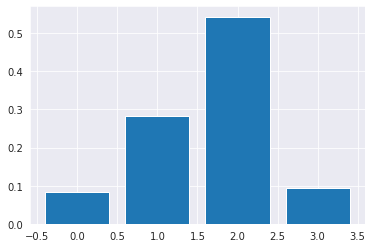

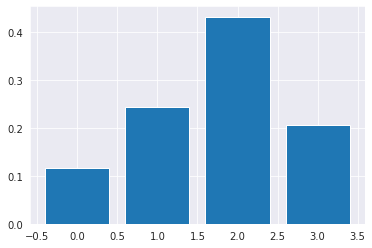

In [49]:

plt.bar(x= [0, 1, 2, 3] ,height=country_independent_result_df.set_index(['country', 'year']).loc[('Italy', 2017)]['PEW'])
plt.figure()
plt.bar(x= [0, 1, 2, 3] ,height=country_independent_result_df.set_index(['country', 'year']).loc[('Italy', 2017)]['predict'])


# Country-year specific model

In [43]:
SAME_COUNTRY_WEIGHT = 1000
country_list = country_year_df['country'].unique()
country_specific_result_df = pd.DataFrame(columns=['country', 'year', 'loss', 'K'])
K = np.arange(1, 9, 2)
for target_country in tqdm(country_list, desc="Countries "):
    test_country_df = country_year_df[country_year_df['country'] == target_country].copy()
    years_in_country = test_country_df['year'].tolist()

    # test_country_df = test_country_df.set_index('year')
    for target_year in years_in_country:
        test_df = test_country_df[test_country_df['year'] == target_year].copy()
        test_df = test_df.set_index('year')
        total_validation_df = test_country_df[test_country_df['year'] != target_year]
        total_validation_df = total_validation_df.set_index(['country','year'])

        total_train_df = country_year_df[(country_year_df['country'] != target_country) |
                                         (country_year_df['year'] != target_year)].copy()
        total_train_df = total_train_df.set_index(['country','year'])


        for validation_year in years_in_country:
            if validation_year == target_year:
                continue


            validation_df = test_country_df[test_country_df['year'] == validation_year]
            validation_df = validation_df.set_index(['year'])
            train_condition = country_year_df['year'].apply(lambda x : x not in [target_year, validation_year])
            train_condition = (train_condition) | (country_year_df['country'] != target_country)
            train_df = country_year_df[train_condition].copy()

            for year, row in validation_df.iterrows():
                val_dist = row['Sentiment_bin20']
                train_df['KL_{}'.format(year)] = train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(val_dist, x))

                sorted_train_df = train_df.sort_values(by='KL_{}'.format(year)).copy()
                sorted_train_df['similarity'] = sorted_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
                sorted_train_df['similarity'] += SAME_COUNTRY_WEIGHT * sorted_train_df['similarity'] * sorted_train_df['country'].apply(lambda x: x==target_country)
                sorted_train_df = sorted_train_df.sort_values(by='similarity',ascending=False)

                for k_num_neighbor in K:
                    best_k_train_df = sorted_train_df.head(n=k_num_neighbor).copy()
                    best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
                    best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW']
                    predict = best_k_train_df['weighted_PEW'].sum()
                    total_validation_df.loc[(target_country, year), 'loss_{}'.format(k_num_neighbor)] = kl_divergence(validation_df.loc[year,'PEW'], predict)

        if len(years_in_country) == 1:
            best_k = 7
        else:
            best_k = total_validation_df[['loss_{}'.format(i) for i in K]].sum().sort_values().head(1).index[0].split('_')[1]
            best_k = int(best_k)

        for year, row in test_df.iterrows():
            test_dist = row['Sentiment_bin20']
            total_train_df['KL_{}'.format(year)] = total_train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(test_dist, x))
            sorted_train_df = total_train_df.sort_values(by='KL_{}'.format(year)).reset_index()
            sorted_train_df['similarity'] = sorted_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
            sorted_train_df['similarity'] += SAME_COUNTRY_WEIGHT * sorted_train_df['similarity'] * sorted_train_df['country'].apply(lambda x: x==target_country)
            sorted_train_df = sorted_train_df.sort_values(by='similarity', ascending=False)

            best_k_train_df = sorted_train_df.head(n=best_k).copy()

            best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
            best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW']
            predict = best_k_train_df['weighted_PEW'].sum()
            test_df.loc[year, 'K'] = best_k
            test_df.loc[year, 'loss'] = kl_divergence(test_df.loc[year,'PEW'], predict)
            country_specific_result_df=pd.concat([country_specific_result_df ,pd.DataFrame.from_records([{'country': target_country,
                                                  'year': year,
                                                  'loss': test_df.loc[year, 'loss'],
                                                  'K': best_k,
                                                                                                                'predict': predict,
                                'similar_countries': best_k_train_df['country'].tolist(),
                                                                                                          'similarity': best_k_train_df['similarity'].tolist(),
                                                                                                         'PEW': test_df.loc[year,'PEW']}])])

country_specific_result_df



Countries : 100%|██████████| 48/48 [00:08<00:00,  5.61it/s]


,country,year,loss,K,predict,similar_countries,similarity,PEW
0,Argentina,2015,0.060551,7,"[0.27899553762161167, 0.27399080519037794, 0.3...","[Argentina, Argentina, Argentina, India, Polan...","[0.446406778513471, 0.28516907639886496, 0.264...","[0.17508813160987075, 0.3219741480611046, 0.39..."
0,Argentina,2017,0.001709,7,"[0.2594665140940478, 0.28373322064660444, 0.32...","[Argentina, Argentina, Argentina, Australia, G...","[0.4972299925051664, 0.26014354172628146, 0.23...","[0.2771672771672772, 0.2857142857142857, 0.316..."
0,Argentina,2018,0.014852,7,"[0.25262964994015247, 0.2798624825975396, 0.33...","[Argentina, Argentina, Argentina, Spain, Mexic...","[0.495314760684944, 0.3341818655639704, 0.1670...","[0.30673316708229426, 0.2805486284289277, 0.28..."
0,Argentina,2019,0.020420,1,"[0.30673316708229426, 0.2805486284289277, 0.28...",[Argentina],[1.0],"[0.25534441805225655, 0.2494061757719715, 0.33..."
0,Australia,2015,0.092062,1,"[0.14636363636363636, 0.3236363636363636, 0.44...",[Australia],[1.0],"[0.06472491909385113, 0.24379719525350593, 0.5..."
...,...,...,...,...,...,...,...,...
0,United Kingdom,2020,0.131689,5,"[0.11512738833728689, 0.2755342353155459, 0.46...","[United Kingdom, United Kingdom, United Kingdo...","[0.3137861235650188, 0.260402675570488, 0.2054...","[0.22966014418125644, 0.35633367662203913, 0.3..."
0,Venezuela,2015,0.012871,3,"[0.27296523481020224, 0.16237674832470458, 0.3...","[Venezuela, Hungary, Philippines]","[0.9975701005303316, 0.0013494121333435818, 0....","[0.2584514721919302, 0.193020719738277, 0.3358..."
0,Venezuela,2017,0.012263,7,"[0.2567169017745045, 0.19431070446811996, 0.33...","[Venezuela, Japan, Pakistan, Canada, Japan, Ca...","[0.9855208774481781, 0.003525894436634462, 0.0...","[0.27350427350427353, 0.1623931623931624, 0.38..."
0,Vietnam,2015,0.032573,7,"[0.011591431049010054, 0.09247713639283933, 0....","[Vietnam, South Korea, Colombia, Kenya, Nether...","[0.9543238816697223, 0.008623400518189425, 0.0...","[0.02292576419213974, 0.1091703056768559, 0.45..."


In [44]:
# country_specific_result_df.sort_values(by='loss')
country_specific_result_df['loss'].describe()

count    163.000000
mean       0.095524
std        0.146864
min        0.000171
25%        0.012883
50%        0.038358
75%        0.110843
max        1.002243
Name: loss, dtype: float64

# classification model

In [7]:
def class2onehot(x):
    y= np.zeros(4)
    y[x] = imbalance_weight[x]
    return y

country_year_df['PEW_class'] = country_year_df['PEW'].apply(lambda x: np.argmax(x))
imbalance_weight = (country_year_df['PEW_class'].sum() / country_year_df['PEW_class'].value_counts()).sort_index().tolist()
country_year_df['PEW_1hot'] = country_year_df['PEW_class'].apply(class2onehot)
country_year_df.sample(n=5)

,country,year,tuple,Sentiment_bin20,PEW,PEW_class,PEW_1hot
24,Kenya,2015,"[(Kenya, 2015), (Kenya, 2016), (Kenya, 2017), ...","[0.06690140845070422, 0.035211267605633804, 0....","[0.04855371900826446, 0.058884297520661155, 0....",3,"[0.0, 0.0, 0.0, 13.619047619047619]"
17,Hungary,2018,"[(Hungary, 2016), (Hungary, 2017), (Hungary, 2...","[0.15600624024961, 0.054602184087363496, 0.046...","[0.050483351235230935, 0.26745435016111707, 0....",2,"[0.0, 0.0, 2.888888888888889, 0.0]"
40,South Korea,2019,"[(South Korea, 2015), (South Korea, 2017), (So...","[0.11212121212121212, 0.07727272727272727, 0.0...","[0.026395939086294416, 0.1949238578680203, 0.6...",2,"[0.0, 0.0, 2.888888888888889, 0.0]"
29,Netherlands,2020,"[(Netherlands, 2016), (Netherlands, 2017), (Ne...","[0.15894039735099338, 0.059602649006622516, 0....","[0.32222222222222224, 0.41515151515151516, 0.2...",1,"[0.0, 11.44, 0.0, 0.0]"
40,South Korea,2018,"[(South Korea, 2015), (South Korea, 2017), (So...","[0.08602771362586605, 0.04503464203233257, 0.0...","[0.024193548387096774, 0.16028225806451613, 0....",2,"[0.0, 0.0, 2.888888888888889, 0.0]"


In [17]:
country_list = country_year_df['country'].unique()
country_independent_result_df = pd.DataFrame(columns=['country', 'year', 'predict'])
K = np.arange(1, 10, 1)
for target_country in tqdm(country_list, desc="Countries "):
    test_df = country_year_df[country_year_df['country'] == target_country]
    test_df = test_df.set_index('year')

    total_validation_df = country_year_df[country_year_df['country'] != target_country]
    total_validation_df = total_validation_df.set_index(['country','year'])
    for validation_country in country_list:
        if validation_country == target_country:
            continue
        validation_df = country_year_df[country_year_df['country'] == validation_country]
        validation_df = validation_df.set_index(['year'])
        train_df = country_year_df[country_year_df['country'].apply(lambda x : x not in [target_country, validation_country])].copy()

        for year, row in validation_df.iterrows():
            val_dist = row['Sentiment_bin20']
            train_df['KL_{}'.format(year)] = train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(val_dist, x))
            sorted_train_df = train_df.sort_values(by='KL_{}'.format(year))
            for k_num_neighbor in K:
                best_k_train_df = sorted_train_df.head(n=k_num_neighbor).copy()
                best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/(1+x))
                best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
                best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW_1hot']
                predict = best_k_train_df['weighted_PEW'].sum()
                total_validation_df.loc[(validation_country, year), 'loss_{}'.format(k_num_neighbor)] = (validation_df.loc[year,'PEW_class'] != np.argmax(predict)) * 1.0
    best_k = total_validation_df[['loss_{}'.format(i) for i in K]].sum().sort_values().head(1).index[0].split('_')[1]
    best_k = int(best_k)

    for year, row in test_df.iterrows():
        test_dist = row['Sentiment_bin20']
        total_validation_df['KL_{}'.format(year)] = total_validation_df['Sentiment_bin20'].apply(lambda x: kl_divergence(test_dist, x))
        sorted_train_df = total_validation_df.sort_values(by='KL_{}'.format(year))

        best_k_train_df = sorted_train_df.head(n=best_k).copy()
        best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/(1+x))
        best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
        best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW_1hot']
        predict = best_k_train_df['weighted_PEW'].sum()
        test_df.loc[year, 'K'] = best_k
        test_df.loc[year, 'loss'] = (test_df.loc[year,'PEW_class'] != np.argmax(predict)) * 1.0
        country_independent_result_df=pd.concat([country_independent_result_df ,pd.DataFrame.from_records([{'country': target_country,
                                              'year': year,
                                              'loss': test_df.loc[year, 'loss'],
                                              'K': best_k,
                                                                                                            'predict': np.argmax(predict),
                                                                                                            'PEW_class': test_df.loc[year,'PEW_class']}])])

country_independent_result_df

Countries : 100%|██████████| 48/48 [04:01<00:00,  5.03s/it]


,country,year,predict,loss,K,PEW_class
0,Argentina,2015,3,1.0,1.0,2.0
0,Argentina,2017,2,0.0,1.0,2.0
0,Argentina,2018,1,1.0,1.0,0.0
0,Argentina,2019,1,1.0,1.0,2.0
0,Australia,2015,2,0.0,1.0,2.0
...,...,...,...,...,...,...
0,United Kingdom,2020,1,0.0,1.0,1.0
0,Venezuela,2015,2,0.0,1.0,2.0
0,Venezuela,2017,2,0.0,1.0,2.0
0,Vietnam,2015,2,0.0,1.0,2.0


In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score

# country_independent_result_df['PEW_class'].value_counts(sort=False).sort_index()
predict = country_independent_result_df['predict'].tolist()
true_label = country_independent_result_df['PEW_class'].tolist()
accuracy_score(true_label, predict)

NameError: name 'country_independent_result_df' is not defined

## Country-year-specific classification

In [9]:
country_list = country_year_df['country'].unique()
country_specific_result_df = pd.DataFrame(columns=['country', 'year', 'loss', 'K'])
K = np.arange(1, 10, 1)
for target_country in tqdm(country_list, desc="Countries "):
    test_country_df = country_year_df[country_year_df['country'] == target_country]
    years_in_country = test_country_df['year'].tolist()

    # test_country_df = test_country_df.set_index('year')
    for target_year in years_in_country:
        test_df = test_country_df[test_country_df['year'] == target_year].copy()
        test_df = test_df.set_index('year')
        total_validation_df = test_country_df[test_country_df['year'] != target_year]
        total_validation_df = total_validation_df.set_index(['country','year'])

        total_train_df = country_year_df[(country_year_df['country'] != target_country) |
                                         (country_year_df['year'] != target_year)]
        total_train_df = total_train_df.set_index(['country','year'])


        for validation_year in years_in_country:
            if validation_year == target_year:
                continue


            validation_df = test_country_df[test_country_df['year'] == validation_year]
            validation_df = validation_df.set_index(['year'])
            train_condition = country_year_df['year'].apply(lambda x : x not in [target_year, validation_year])
            train_condition = (train_condition) | (country_year_df['country'] != target_country)
            train_df = country_year_df[train_condition].copy()

            for year, row in validation_df.iterrows():
                val_dist = row['Sentiment_bin20']
                train_df['KL_{}'.format(year)] = train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(val_dist, x))
                sorted_train_df = train_df.sort_values(by='KL_{}'.format(year))
                for k_num_neighbor in K:
                    best_k_train_df = sorted_train_df.head(n=k_num_neighbor).copy()
                    best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
                    best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
                    best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW_1hot']
                    predict = best_k_train_df['weighted_PEW'].sum()
                    total_validation_df.loc[(target_country, year), 'loss_{}'.format(k_num_neighbor)] = (validation_df.loc[year,'PEW_class'] != np.argmax(predict)) * 1.0

        if len(years_in_country) == 1:
            best_k = 1
        else:
            best_k = total_validation_df[['loss_{}'.format(i) for i in K]].sum().sort_values().head(1).index[0].split('_')[1]
            best_k = int(best_k)

        for year, row in test_df.iterrows():
            test_dist = row['Sentiment_bin20']
            total_train_df['KL_{}'.format(year)] = total_train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(test_dist, x))
            sorted_train_df = total_train_df.sort_values(by='KL_{}'.format(year))

            best_k_train_df = sorted_train_df.head(n=best_k).copy()
            best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
            best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
            best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW_1hot']
            predict = best_k_train_df['weighted_PEW'].sum()
            test_df.loc[year, 'K'] = best_k
            test_df.loc[year, 'loss'] = (test_df.loc[year,'PEW_class'] != np.argmax(predict)) * 1.0
            country_specific_result_df=pd.concat([country_specific_result_df ,pd.DataFrame.from_records([{'country': target_country,
                                                  'year': year,
                                                  'loss': test_df.loc[year, 'loss'],
                                                  'K': best_k,
                                                                                                                'predict': np.argmax(predict),
                                                                                                          'similar_countries': best_k_train_df.index.tolist(),
                                                                                                               'PEW': test_df.loc[year,'PEW_class']}])])

country_specific_result_df



Countries : 100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


,country,year,loss,K,predict,similar_countries,PEW
0,Argentina,2015,1.0,2,3.0,"[(India, 2015), (Poland, 2015)]",2.0
0,Argentina,2017,0.0,2,2.0,"[(Australia, 2015), (Germany, 2015)]",2.0
0,Argentina,2018,1.0,1,1.0,"[(Spain, 2017)]",0.0
0,Argentina,2019,1.0,2,1.0,"[(Spain, 2017), (Israel, 2019)]",2.0
0,Australia,2015,0.0,1,2.0,"[(United Kingdom, 2015)]",2.0
...,...,...,...,...,...,...,...
0,United Kingdom,2020,1.0,1,2.0,"[(United Kingdom, 2016)]",1.0
0,Venezuela,2015,0.0,1,2.0,"[(Hungary, 2019)]",2.0
0,Venezuela,2017,0.0,1,2.0,"[(Japan, 2018)]",2.0
0,Vietnam,2015,0.0,1,2.0,"[(South Korea, 2015)]",2.0


In [21]:
predict = country_specific_result_df['predict'].tolist()
true_label = country_specific_result_df['PEW'].tolist()
confusion_matrix(true_label, predict)

array([[ 0,  5, 11,  2],
       [ 2,  7, 13,  3],
       [ 3, 19, 62, 15],
       [ 0,  4, 14,  3]])

In [ ]:
country_specific_result_df

# Visualization

LOCO Loss: 0.0054816010071229
SCV Loss: 0.0012157120891021


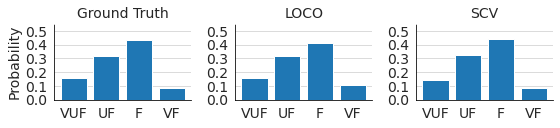

In [35]:
def list_to_np(x):
    list_str = x.strip("[]").split(' ')
    list_float = [float(i) for i in list_str if len(i) > 1]
    return list_float
# loco = country_independent_result_df.set_index(['country', 'year']).copy()
# locyo = country_specific_result_df.set_index(['country', 'year']).copy()
loco = pd.read_csv('loco.csv').set_index(['country', 'year'])
locyo = pd.read_csv('locyo.csv').set_index(['country', 'year'])
loco['PEW'] = loco['PEW'].apply(list_to_np)
locyo['PEW'] = locyo['PEW'].apply(list_to_np)
loco['predict'] = loco['predict'].apply(list_to_np)
locyo['predict'] = locyo['predict'].apply(list_to_np)
country, year = 'Australia', 2019

print("LOCO Loss:", loco.loc[(country, year)]['loss'])
print("SCV Loss:", locyo.loc[(country, year)]['loss'])

ticks = ['VUF', 'UF', 'F', 'VF']
plt.rcParams['font.size'] = 14
f, axes = plt.subplots(1, 3, figsize = (8,2))
axes[0].set_ylabel('Probability')
axes[0].bar(x=ticks, height = loco.loc[(country, year)]['PEW'])
axes[0].set_title("Ground Truth", fontsize=14)
axes[1].bar(x= ticks, height=loco.loc[(country, year)]['predict'])
axes[1].set_title('LOCO', fontsize=14)
axes[2].bar(x= ticks, height=locyo.loc[(country, year)]['predict'])
axes[2].set_title('SCV', fontsize=14)

for i in range(3):
    axes[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    axes[i].yaxis.grid(True, color="lightgray")
    axes[i].spines['left'].set_color('black')
    axes[i].spines['bottom'].set_color('black')
    axes[i].set_facecolor("None")
    axes[i].set_ylim([0,0.55])

plt.tight_layout()
plt.savefig('output/results/{}_{}.png'.format(country, year), dpi=300, bbox_inches='tight')




In [25]:

loco.sort_values(by='loss')

,,loss,K,predict,PEW
country,year,,,,
Indonesia,2017,0.004322,7,"[0.15679543, 0.35023118, 0.4247308, 0.06824258]","[0.12955032, 0.3608137, 0.43683084, 0.07280514]"
Australia,2019,0.005482,7,"[0.15770014, 0.31877437, 0.41349325, 0.11003224]","[0.16099071, 0.31888545, 0.43550052, 0.08462332]"
Canada,2019,0.006340,7,"[0.13618347, 0.33720661, 0.41333146, 0.11327845]","[0.16276704, 0.32349949, 0.41912513, 0.09460834]"
Slovakia,2019,0.009128,7,"[0.1550581, 0.30077182, 0.43654345, 0.10762663]","[0.12591815, 0.3452256, 0.4270724, 0.10178384]"
Bulgaria,2019,0.009402,7,"[0.11004124, 0.26379699, 0.44325993, 0.18290184]","[0.14605544, 0.24093817, 0.43176972, 0.18123667]"
...,...,...,...,...,...
Nigeria,2015,0.917473,7,"[0.112667, 0.28051418, 0.47421207, 0.13260675]","[0.06796117, 0.06796117, 0.25674218, 0.60733549]"
South Africa,2015,0.922096,7,"[0.16378775, 0.34286122, 0.39556993, 0.0977811]","[0.09423503, 0.07982262, 0.29711752, 0.52882483]"
Ethiopia,2015,1.002243,7,"[0.13285571, 0.22654132, 0.49233521, 0.14826776]","[0.03745743, 0.03291714, 0.27809308, 0.65153235]"


In [31]:
loco = country_independent_result_df.set_index(['country', 'year']).copy()
loco.to_csv('loco.csv')

NameError: name 'country_independent_result_df' is not defined

# Correlation

In [36]:
df_count_group = df.groupby(['nationality', 'year']).size().reset_index(name='number_quote')
df_count_group = pd.merge(left=df_count_group, right=loco, left_on=['nationality', 'year'], right_on=['country', 'year'], how='inner', suffixes=('_quotebank', '_PEW'))
df_count_group

,nationality,year,number_quote,loss,K,predict,PEW
0,Argentina,2015,1049,0.415876,7,"[0.05108361, 0.13569314, 0.50301606, 0.3102072]","[0.17508813, 0.32197415, 0.39952996, 0.10340776]"
1,Argentina,2017,734,0.233015,7,"[0.09159611, 0.26642429, 0.49488583, 0.14709377]","[0.27716728, 0.28571429, 0.31623932, 0.12087912]"
2,Argentina,2018,885,0.086108,7,"[0.19017242, 0.3338314, 0.38675052, 0.08924565]","[0.30673317, 0.28054863, 0.28054863, 0.13216958]"
3,Argentina,2019,712,0.038757,7,"[0.19207804, 0.22141996, 0.34323307, 0.24326894]","[0.25534442, 0.24940618, 0.33372922, 0.16152019]"
4,Australia,2015,8860,0.053343,7,"[0.13416553, 0.28937149, 0.46121257, 0.11525041]","[0.06472492, 0.2437972, 0.5587918, 0.13268608]"
...,...,...,...,...,...,...,...
158,United Kingdom,2020,7685,0.011443,7,"[0.18615154, 0.3669009, 0.37179652, 0.07515104]","[0.22966014, 0.35633368, 0.32955716, 0.08444902]"
159,Venezuela,2015,539,0.068636,7,"[0.15892305, 0.18782405, 0.46492318, 0.18832972]","[0.25845147, 0.19302072, 0.33587786, 0.21264995]"
160,Venezuela,2017,1001,0.208689,7,"[0.12766186, 0.28067501, 0.50342787, 0.08823526]","[0.27350427, 0.16239316, 0.38339438, 0.18070818]"
161,Vietnam,2015,55,0.319017,7,"[0.12754823, 0.22065821, 0.48123776, 0.1705558]","[0.02292576, 0.10917031, 0.45742358, 0.41048035]"


/tmp/ipykernel_9769/3252466209.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


<Figure size 576x432 with 0 Axes>

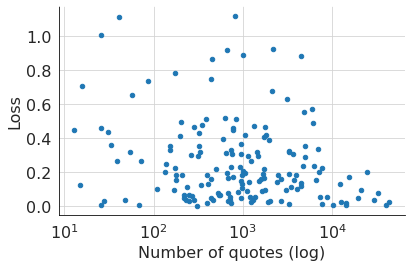

In [38]:
plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 16
df_count_group.plot.scatter(x='number_quote', y='loss', logx=True)
ax = plt.axes()
ax.set_facecolor("None")
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_xlabel('Number of quotes (log)')
ax.set_ylabel('Loss')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True, color='lightgray')
plt.tight_layout()
plt.savefig('output/results/corr_loco.png', dpi=300, bbox_inches='tight')

In [39]:
from scipy.stats import pearsonr
pearsonr(np.log(df_count_group['number_quote']), df_count_group['loss'])

PearsonRResult(statistic=-0.23208657134046667, pvalue=0.0028722109033138613)

In [40]:
t = np.linspace(0, 10*np.pi, 10000)
pearsonr(df_count_group['number_quote'], -(df_count_group['number_quote']))

PearsonRResult(statistic=-1.0, pvalue=0.0)

# The time tunnel

In [41]:
df_count_group = df.groupby(['nationality', 'year']).size().reset_index(name='number_quote')
df_count_group[df_count_group['number_quote'] > 700]

,nationality,year,number_quote
36,Argentina,2015,1049
38,Argentina,2017,734
39,Argentina,2018,885
40,Argentina,2019,712
48,Australia,2015,8860
...,...,...,...
1042,United States,2018,386183
1043,United States,2019,329477
1044,United States,2020,94111
1070,Venezuela,2017,1001


In [42]:
new_country_list = ['Switzerland', 'Cuba', 'Norway', 'Iran', 'Jamaica', 'New Zealand']
country_list = country_year_df['country'].unique()


time_tunnel_independent_result_df = pd.DataFrame(columns=['country', 'year', 'loss', 'K'])
K = np.arange(1, 8)
for target_country in tqdm(new_country_list, desc="Countries "):
    new_country_year_df = pd.DataFrame(columns=['country', 'year'])
    for year in range(2015, 2021):
        new_country_year_df = pd.concat([new_country_year_df, pd.DataFrame.from_records([{'country': target_country, 'year': year}])])
    new_country_year_df['Sentiment_bin20'] = new_country_year_df.apply(get_q_dist, axis=1)
    new_country_year_df = pd.concat([country_year_df, new_country_year_df])
    test_df = new_country_year_df[new_country_year_df['country'] == target_country]
    test_df = test_df.set_index('year')

    total_validation_df = new_country_year_df[new_country_year_df['country'] != target_country]
    total_validation_df = total_validation_df.set_index(['country','year'])
    for validation_country in country_list:
        if validation_country == target_country:
            continue
        validation_df = new_country_year_df[new_country_year_df['country'] == validation_country]
        validation_df = validation_df.set_index(['year'])
        train_df = new_country_year_df[new_country_year_df['country'].apply(lambda x : x not in [target_country, validation_country])].copy()

        for year, row in validation_df.iterrows():
            val_dist = row['Sentiment_bin20']
            train_df['KL_{}'.format(year)] = train_df['Sentiment_bin20'].apply(lambda x: kl_divergence(val_dist, x))
            sorted_train_df = train_df.sort_values(by='KL_{}'.format(year))
            for k_num_neighbor in K:
                best_k_train_df = sorted_train_df.head(n=k_num_neighbor).copy()
                best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
                best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
                best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW']
                predict = best_k_train_df['weighted_PEW'].sum()
                total_validation_df.loc[(validation_country, year), 'loss_{}'.format(k_num_neighbor)] = kl_divergence(validation_df.loc[year,'PEW'], predict)

    best_k = total_validation_df[['loss_{}'.format(i) for i in K]].sum().sort_values().head(1).index[0].split('_')[1]
    best_k = int(best_k)

    for year, row in test_df.iterrows():
        test_dist = row['Sentiment_bin20']
        total_validation_df['KL_{}'.format(year)] = total_validation_df['Sentiment_bin20'].apply(lambda x: kl_divergence(test_dist, x))
        sorted_train_df = total_validation_df.sort_values(by='KL_{}'.format(year))

        best_k_train_df = sorted_train_df.head(n=best_k).copy()
        best_k_train_df['similarity'] = best_k_train_df['KL_{}'.format(year)].apply(lambda x: 1/x)
        best_k_train_df['similarity'] /= best_k_train_df['similarity'].sum()
        best_k_train_df['weighted_PEW'] = best_k_train_df['similarity'] * best_k_train_df['PEW']
        predict = best_k_train_df['weighted_PEW'].sum()
        test_df.loc[year, 'K'] = best_k
        time_tunnel_independent_result_df=pd.concat([time_tunnel_independent_result_df ,pd.DataFrame.from_records([{'country': target_country,
                                              'year': year,
                                              'K': best_k,
                                                                                                            'predict': predict}])])

time_tunnel_independent_result_df

Countries : 100%|██████████| 6/6 [01:18<00:00, 13.00s/it]


,country,year,loss,K,predict
0,Switzerland,2015,NaN,7,"[0.14423113144722674, 0.3248965018425489, 0.44..."
0,Switzerland,2016,NaN,7,"[0.1473085067154868, 0.27058953945121605, 0.44..."
0,Switzerland,2017,NaN,7,"[0.22973098655931523, 0.2928586090548144, 0.39..."
0,Switzerland,2018,NaN,7,"[0.2007553887031256, 0.3258968338594549, 0.370..."
0,Switzerland,2019,NaN,7,"[0.18441157328916136, 0.3169262231636544, 0.41..."
0,Switzerland,2020,NaN,7,"[0.10022911677905678, 0.23779045772618404, 0.4..."
0,Cuba,2015,NaN,7,"[0.12035468771994587, 0.2754160001352546, 0.47..."
0,Cuba,2016,NaN,7,"[0.14276533925339546, 0.3253398893493126, 0.41..."
0,Cuba,2017,NaN,7,"[0.18821568673338468, 0.30893571612232107, 0.4..."
0,Cuba,2018,NaN,7,"[0.08150131833307667, 0.1588841465274516, 0.44..."


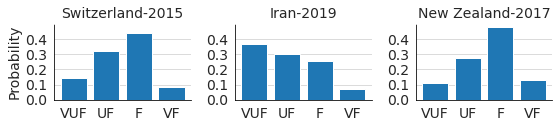

In [43]:
Iran2019 = [0.37156494076126845, 0.30067258605140773, 0.25806007466190817, 0.06970239852541586]
Switzerland2015 = [0.14423113144722674, 0.3248965018425489, 0.4432234769611309, 0.08764888974909343]
NewZealand2017 = [0.11033463733055648, 0.2786068696305469, 0.48280374641081786, 0.1282547466280788]
ticks = ['VUF', 'UF', 'F', 'VF']
plt.rcParams['font.size'] = 14
f, axes = plt.subplots(1, 3, figsize = (8,2))
axes[0].set_ylabel('Probability')
# plt.title('Switzerland-2015')
axes[0].bar(x=ticks, height = Switzerland2015)
axes[0].set_title("Switzerland-2015", fontsize=14)
axes[1].bar(x= ticks, height=Iran2019)
axes[1].set_title('Iran-2019', fontsize=14)
axes[2].bar(x= ticks, height=NewZealand2017)
axes[2].set_title('New Zealand-2017', fontsize=14)

for i in range(3):
    axes[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
    axes[i].yaxis.grid(True, color="lightgray")
    axes[i].spines['left'].set_color('black')
    axes[i].spines['bottom'].set_color('black')
    axes[i].set_facecolor("None")
    axes[i].set_ylim([0,0.5])
plt.tight_layout()
plt.savefig('output/results/time_tunnel', dpi=300, bbox_inches='tight')

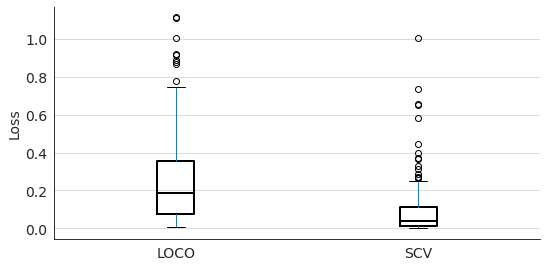

In [44]:
f, ax = plt.subplots(figsize=(8,4))
boxprops = dict(linewidth=2, color = 'k')

plt.rcParams['font.size'] = 16
merged = pd.merge(loco, locyo, on=loco.index, suffixes=['_LOCO', '_SCV'])
merged = merged.rename(columns={'loss_LOCO': 'LOCO', 'loss_SCV': 'SCV'})
merged.boxplot(column=['LOCO', 'SCV'], ax=ax, boxprops=boxprops, medianprops=boxprops)
ax.yaxis.grid(True, color="lightgray")
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_facecolor("None")
ax.set_ylabel("Loss")
plt.tight_layout()
plt.savefig('output/results/loss', dpi=300, bbox_inches='tight')
